In [19]:
from time import time
import pandas as pd
import numpy as np
from PIL import Image
import keras.layers.advanced_activations
import scipy
import random
import matplotlib.pyplot as plt  
from scipy.stats import norm  
import keras
from keras.models import Sequential
from keras.initializers import VarianceScaling,RandomNormal
from keras.layers import Input, Dense, Dropout, Conv2D, MaxPooling2D,concatenate
from keras.layers import UpSampling2D, Reshape, Lambda, Flatten, Activation
from keras.models import Model  
from keras.optimizers import SGD, Adadelta, Adagrad,Adam
from keras import backend as K  
from keras import objectives  
from keras.utils.vis_utils import plot_model  
from keras.utils import np_utils, generic_utils
import sys 
import tensorflow as tf
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.layers.normalization import BatchNormalization
import matplotlib.pyplot as plt
import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import sklearn
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter
%matplotlib inline
from sklearn import manifold, datasets,cluster
from sklearn.utils import check_random_state
random.seed(1)

In [2]:
path = os.listdir('cstor/xsede/users/xs-haosun/SDSS_2000/')

Obj_ID = []
Image = []
Class = []
Redshift = []
for i in range(len(path)):
    path_now = path[i]
    a = np.load('cstor/xsede/users/xs-haosun/SDSS_2000/'+str(path_now))
    for j in range(a.shape[0]):
        Obj_ID.append(a[j]['objID'])
        Image.append(a[j]['image'])
        Class.append(a[j]['class'])
        Redshift.append(a[j]['z'])

Obj_ID = np.asarray(Obj_ID)
Image = np.asarray(Image)
Class = np.asarray(Class)
Redshift = np.asarray(Redshift)
Class[Class=='STAR'] = 0
Class[Class=='GALAXY'] = 1
Class[Class=='QSO'] = 2
Class = Class.astype(int)

In [3]:
Image_RGB = np.empty((len(Image),64,64))#(14142,64,64,1) one channel images
for i in range(len(Image)):
    #b[i] = np.stack((a[i][1][0],a[i][1][1],a[i][1][2],a[i][1][3],a[i][1][4]),axis=-1)
    Image_RGB[i] = Image[i][2]


for i in range(len(Image_RGB)):
    if True in np.isnan(Image_RGB[i]).reshape(64*64*1):
        print(i)
        Image_RGB[i][np.isnan(Image_RGB[i])==True]=np.mean(Image_RGB[i-1])

In [4]:
#Image_RGB =(1- ( (Image_RGB - np.min(Image_RGB))/(np.max(Image_RGB) - np.min(Image_RGB))))*2 - 1

Image_RGB /= np.max(Image_RGB)
Image_RGB -= np.mean(Image_RGB)
Image_RGB = -Image_RGB

In [5]:
label = np_utils.to_categorical(Class, 3)
data = Image_RGB.reshape(-1,64,64,1)
index = [i for i in range(len(data))]
#random.shuffle(index)
train_data = data[index]
train_label = label[index]
#Class = Class[index]
#Redshift = Redshift[index]
#show_Image_RGB = show_Image_RGB[index]
print('train_data.shape:',train_data.shape)
print('train_label.shape:',train_label.shape)

train_data.shape: (14142, 64, 64, 1)
train_label.shape: (14142, 3)


In [33]:
batch_size =100
latent_dim = 30
nb_epoch = 50  
epsilon_std =5.0
intermediate_dim_1 = 600
#intermediate_dim_2 = 300
original_dim = 64*64

input_img = Input(shape=(64,64,1))

conv_1 = Conv2D(80, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(input_img)
maxpool_1 = Conv2D(80, (3, 3), strides=(2, 2), activation='tanh', padding='same',kernel_initializer='normal')(conv_1)
#maxpool_1 = MaxPooling2D((2, 2),  padding='same')(conv_1)

conv_2 = Conv2D(80, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(maxpool_1)
maxpool_2 = Conv2D(80, (3, 3), strides=(2, 2), activation='tanh', padding='same',kernel_initializer='normal')(conv_2)
#maxpool_2 = MaxPooling2D((2, 2),  padding='same')(conv_2)

conv_3 = Conv2D(80, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(maxpool_2)
maxpool_3 = Conv2D(80, (3, 3), strides=(2, 2), activation='tanh', padding='same',kernel_initializer='normal')(conv_3)
#maxpool_3 = MaxPooling2D((2, 2),  padding='same')(conv_3)

conv_4 = Conv2D(80, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(maxpool_3)
#maxpool_4 = MaxPooling2D((2, 2),  padding='same')(conv_4)

#conv_5 = Conv2D(80, (3, 3), activation='tanh', padding='same',kernel_initializer='normal')(maxpool_4)
#maxpool_5 = MaxPooling2D((2, 2),  padding='same')(conv_5)

#x = Conv2D(5, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
#x = MaxPooling2D((2, 2),  padding='same')(x)

visual = Flatten()(conv_4)
h_1 = Dense(intermediate_dim_1, activation='relu')(visual)
#h_2 = Dense(intermediate_dim_2, activation='tanh')(h_1)

z_mean = Dense(latent_dim)(h_1)
z_log_var = Dense(latent_dim)(h_1)

def sampling(args):   
    z_mean, z_log_var = args  
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.,stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2)* epsilon

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

#h_3 = Dense(intermediate_dim_2,activation='tanh')(z)
h_4 = Dense(intermediate_dim_1,activation='tanh')(z)
h_5 = Dense(80*8*8,activation='relu')(h_4)
h_6 = Reshape((8,8,80))(h_5)


#conv_6 = Conv2D(80, (3, 3), activation='tanh', padding='same',kernel_initializer='normal')(h_6)
#upsample_6 = UpSampling2D((2, 2))(conv_6)
h_6 = concatenate([h_6,conv_4])
conv_7 = Conv2D(80, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(h_6)
#upsample_7 = UpSampling2D((2, 2))(conv_7)

conv_7 = concatenate([conv_7,conv_4])
conv_8 = Conv2D(80, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(conv_7)
upsample_8 = UpSampling2D((2, 2))(conv_8)

upsample_8 = concatenate([upsample_8,conv_3])
conv_9 = Conv2D(80, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(upsample_8)
upsample_9 = UpSampling2D((2, 2))(conv_9)

upsample_9 = concatenate([upsample_9,conv_2])
conv_10 = Conv2D(80,  (3, 3), activation='tanh',padding='same',kernel_initializer='normal')(upsample_9)
upsample_10 = UpSampling2D((2, 2))(conv_10)

decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(upsample_10)

EarlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')


def vae_loss(x, decoded):  
    xent_loss = K.sum(K.sum(objectives.binary_crossentropy(x ,decoded),axis=-1),axis=-1)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1) 
    return xent_loss + 10*kl_loss  


vae = Model(inputs=input_img, outputs=decoded)
vae.compile(optimizer='rmsprop', loss=vae_loss)



In [34]:
vae.fit(train_data[:14000], train_data[:14000],
        shuffle=True,
        epochs=50,
        batch_size=batch_size,
        validation_data=(train_data[14000:14100],train_data[14000:14100]),callbacks=[EarlyStopping])

Train on 14000 samples, validate on 100 samples
Epoch 1/50
14000/14000 [==============================] - 46s - loss: -25.4135 - val_loss: -78.2215
Epoch 2/50
14000/14000 [==============================] - 45s - loss: -96.4771 - val_loss: -76.6920
Epoch 3/50
14000/14000 [==============================] - 45s - loss: -99.8401 - val_loss: -85.6854
Epoch 4/50
14000/14000 [==============================] - 45s - loss: -102.1551 - val_loss: -83.1082
Epoch 5/50
14000/14000 [==============================] - 45s - loss: -104.9947 - val_loss: -91.0180
Epoch 6/50
14000/14000 [==============================] - 45s - loss: -108.3580 - val_loss: -92.6753
Epoch 7/50
14000/14000 [==============================] - 45s - loss: -111.6504 - val_loss: -96.3095
Epoch 8/50
14000/14000 [==============================] - 45s - loss: -114.6169 - val_loss: -98.7855
Epoch 9/50
14000/14000 [==============================] - 45s - loss: -117.2668 - val_loss: -101.3516
Epoch 10/50
14000/14000 [====================

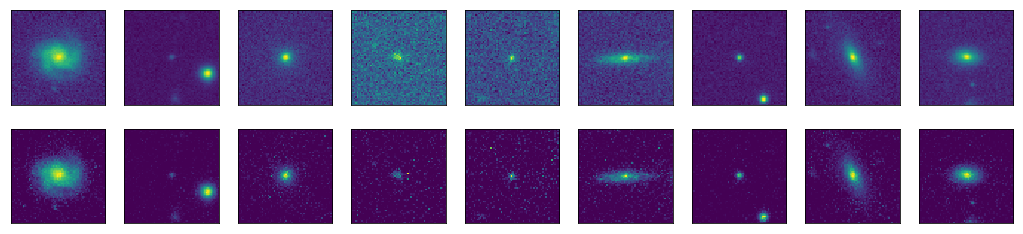

In [35]:
# encode and decode some digits
# note that we take them from the *test* set
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt

#encoded_imgs = encoder.predict(x_test)


decoded_imgs = vae.predict(train_data[8000:9500],batch_size=100)

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(1,n):
    # display original
    ax = plt.subplot(2,n,i)
    plt.imshow((train_data[8000:9500][i][:,:,0]))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n ,i + n)
    plt.imshow((decoded_imgs[i][:,:,0]))
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [72]:
#vae.save_weights("no_distortion0810.h5")

In [36]:
model_conv_1 = Model(input_img,conv_1)
model_pool_1 = Model(input_img,maxpool_1)
model_conv_2 = Model(input_img,conv_2)
model_pool_2 = Model(input_img,maxpool_2)
model_conv_3 = Model(input_img,conv_3)
model_pool_3 = Model(input_img,maxpool_3)
model_conv_4 = Model(input_img,conv_4)
#model_pool_4 = Model(input_img,maxpool_4)
#model_conv_5 = Model(input_img,conv_5)
#model_pool_5 = Model(input_img,maxpool_5)
#model_conv_6 = Model(input_img,conv_6)
#model_up_6 = Model(input_img,upsample_6)
model_conv_7 = Model(input_img,conv_7)
#model_up_7 = Model(input_img,upsample_7)
model_conv_8 = Model(input_img,conv_8)
model_up_8 = Model(input_img,upsample_8)
model_conv_9 = Model(input_img,conv_9)
model_up_9 = Model(input_img,upsample_9)
model_conv_10 = Model(input_img,conv_10)
model_up_10 = Model(input_img,upsample_10)
lyr = []
lyr.append(model_conv_1)
lyr.append(model_pool_1)
lyr.append(model_conv_2)
lyr.append(model_pool_2)
lyr.append(model_conv_3)
lyr.append(model_pool_3)
lyr.append(model_conv_4)
#lyr.append(model_pool_4)
#lyr.append(model_conv_5)
#lyr.append(model_pool_5)
#lyr.append(model_conv_6)
#lyr.append(model_up_6)
lyr.append(model_conv_7)
#lyr.append(model_up_7)
lyr.append(model_conv_8)
lyr.append(model_up_8)
lyr.append(model_conv_9)
lyr.append(model_up_9)
lyr.append(model_conv_10)
lyr.append(model_up_10)
lyr.append(vae)

In [49]:
import scipy
RANGE=40
total_hyp = []
for No_ in range(RANGE):
    hypercolumns = []
    hypercolumns_class = []
    for i in [0,1,2,3,4,5,14,14,14,14,14,14,14,14,14,14]:
        for l in range(lyr[i].output_shape[3]):
            hypercolumns.append(scipy.misc.imresize(lyr[i].predict(train_data[10200:10300],batch_size=100)[No_,:,:,l],size=(64,64),mode="F", interp='bilinear'))
    total_hyp.append(hypercolumns)

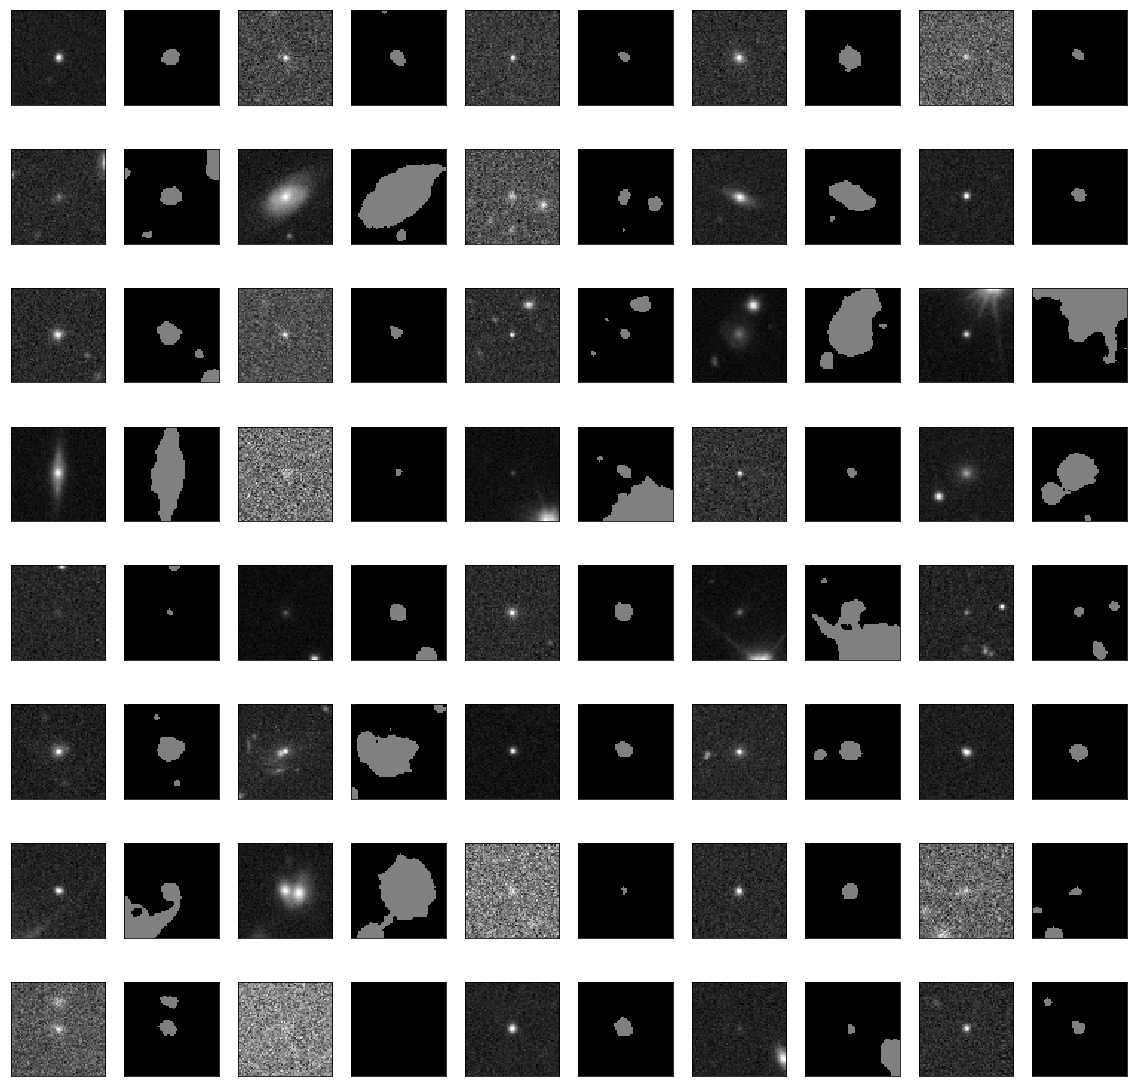

In [50]:
total_hyp = np.asarray(total_hyp)
m=total_hyp.transpose(0,2,3,1).reshape(64*64*RANGE,-1)
#db = DBSCAN(eps=0.5, min_samples=200).fit(m)
#cluster_labels = db.labels_
kmeans = cluster.KMeans(n_clusters=2, max_iter=300, n_jobs=1, precompute_distances=True)
#SC = SpectralClustering(n_clusters=2).fit(m)
cluster_labels = kmeans.fit_predict(m)
imcluster = cluster_labels
for i in range(RANGE):
    imcluster[i*64*64:(i+1)*64*64][0]=0
    imcluster[i*64*64:(i+1)*64*64][1]=1
    imcluster[i*64*64:(i+1)*64*64][2]=2

fig = plt.figure(figsize=(20, 20))

for i in range(RANGE):
    ax = plt.subplot(8,10,i*2+1)
    plt.gray()
    plt.imshow(train_data[10200:10300][i,:,:,0])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(8,10,i*2+2)
    plt.imshow(imcluster[i*64*64:(i+1)*64*64].reshape(64, 64))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()